In [10]:
# Application of https://pypi.org/project/pyworkforce/ to Scout call center problem
! pip install pyworkforce 

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [16]:
from pyworkforce.queuing import ErlangC

# Problem: Find the number of agents needed in a call center to handle incoming traffic of calls assuming
# in a time interval of 30 minutes there is an average of 100 incoming calls, the AHT is 3 minutes, and the expected
# shrinkage is 15%. We want the average time that a transaction waits in the queue to be 20 seconds and achieve
# a service level of 80%. We also want to ensure that the maximum occupancy of the agents is not greater than 85%.

mtig = 300 # minutes
assist_time = 3 # minutes, includes connect time, context time, and actual active time assisting bot
peak_bots = 1000 # the maximum # of bots requiring TO monitoring simultaneous (e.g., when bots in all time zones are running)
teleassist_requests_per_hr = peak_bots * 60 / (mtig+assist_time)

erlang = ErlangC(transactions=teleassist_requests_per_hr, asa=20/60, aht=assist_time, interval=60, shrinkage=0.15)

requirements = erlang.required_positions(service_level=0.8, max_occupancy=0.85)

print(requirements)

mtig_values = [1,2,3,4,5,10,15,20,25,50,75,100,200,300,1000] # minutes
print('| {:>10} | {:>10} | {:>10} | '.format("MTIG", "% in Green", "TO Ratio"))
for mtig in mtig_values:
    teleassist_requests_per_hr = peak_bots * 60 / (mtig+assist_time)
    # erlang = ErlangC(transactions=teleassist_requests_per_hr, asa=20/60, aht=assist_time, interval=60, shrinkage=0.15)
    requirements = ErlangC(transactions=teleassist_requests_per_hr, asa=20/60, aht=assist_time, interval=60, shrinkage=0.15).required_positions(service_level=0.8, max_occupancy=0.85)
    to_ratio = peak_bots / requirements["positions"]
    pct_green = mtig / (mtig + assist_time)
    print('| {:>10} | {:>10.0%} | {:>10.1f} | '.format(mtig, pct_green, to_ratio))

{'raw_positions': 13, 'positions': 16, 'service_level': 0.8084193926488892, 'occupancy': 0.7616146230007617, 'waiting_probability': 0.2703299039517425}
|       MTIG | % in Green |   TO Ratio | 
|          1 |        25% |        1.0 | 
|          2 |        40% |        1.2 | 
|          3 |        50% |        1.4 | 
|          4 |        57% |        1.7 | 
|          5 |        62% |        1.9 | 
|         10 |        77% |        3.1 | 
|         15 |        83% |        4.3 | 
|         20 |        87% |        5.5 | 
|         25 |        89% |        6.7 | 
|         50 |        94% |       12.7 | 
|         75 |        96% |       18.2 | 
|        100 |        97% |       23.8 | 
|        200 |        99% |       43.5 | 
|        300 |        99% |       62.5 | 
|       1000 |       100% |      166.7 | 


In [11]:
from matplotlib import pyplot as plt
from pyworkforce.queuing import ErlangC
import pandas as pd
import math

def erlang_c(cols):
    # The way Erlang C finds the number of resources in this system is by finding the probability that a transaction 
    # waits in queue, opposed to immediately being attended, it takes a target ASA and service level and uses the others
    # variables as the system parameters. It returns the following outputs:
    # - Raw Positions: Number of TO heads predicted assuming shrinkage = 0
    # - Positions: Number of TO heads predicted taking the target shrinkage
    # - Service Level: The expected percentage of transactions that don't wait in the queue longer than the target ASA
    # - Waiting Probability: The probability that a transaction waits in queue
    #
    # Model Assumptions
    # - There is incoming traffic with a constant rate; the arrivals follow a Poisson process
    # - There is a fixed capacity in the system; usually, only one transaction gets handled by a given resource at the time
    # - There is a fixed number of available positions in a time interval
    # - When all the positions have a total capacity, there is an infinite queue length where the requests wait for a position
    #   to be free.
    # - An exponential distribution describes the holding times in the queue (Poisson and exponential distribution are
    #   mathematically related)
    # - There is no dropout from the queue, i.e., there is no call abandonment. It assumes that all callers will remain in the
    #   queue until they are being served. This is a good assumption for Scout, though for call centers some callers will 
    #   abandon when the waiting time exceeds their patience.
    erlang = ErlangC(transactions=cols['Assist_reqs_per_hr'], asa=cols[ 'Tgt_ASA'], aht=cols['AHT'], 
                     interval=cols['Time_interval'], shrinkage=cols['Pct_TO_unavailable'])
    requirements = erlang.required_positions(service_level=cols['Tgt_service_level'], max_occupancy=cols['Max_occupancy'])
    col1 = requirements['raw_positions']
    col2 = requirements['positions']
    col3 = requirements['service_level']
    col4 = requirements['occupancy']
    col5 = requirements['waiting_probability']
    return cols.append(pd.Series([col1, col2, col3, col4, col5], index=['Raw_positions', 'Positions', 'Service_level',
                                                                       'Achieved_occupancy', 'Wait_probability']))
# Helper function for probability of wait calc
def p_wait(A, N):
    x= pow(A,N)/math.factorial(int(N))*N/(N-A)
    y= sum(pow(A,i)/math.factorial(i) for i in range(0,int(N)))
    return x/(y+x)

# Creates dataframe of model inputs and outputs
def erlang_df(mtig, aht=3, peak_bots=1000, interval=60, tgt_asa=20/60, shrinkage=0, tgt_service_level=0.9, max_occupancy=0.85, check=False):

    # Mean time in green (MTIG): Required argument, should be a list. Mean time in green in minutes.

    # Average handle time (AHT): The average time in minutes for a teleoperator to assist a bot, including connect time, context adjustment,
    # and restarting autonomy
    if not isinstance(aht, list):
        aht = [aht]*len(mtig)

    # Peak bots: The number of bots in the hour with the most bots operating simultaneously
    if not isinstance(peak_bots, list):
        peak_bots = [peak_bots]*len(mtig)
    
    # Interval: A time period we are modeling for. For our case, this is the hour when peak bots are running (i.e., bots
    # from all of Scout's operating time zones are running simultaneously)
    if not isinstance(interval, list):
        interval = [interval]*len(mtig)

    # Target average speed of answer (ASA): Target average time in minutes that a transaction waits in the queue to
    # be attended by a TO
    if not isinstance(tgt_asa, list):
        tgt_asa = [tgt_asa]*len(mtig)

    # Target shrinkage: Expected percentage of time that a teleoperator is not available, for example, due to breaks,
    # scheduled training, etc.
    if not isinstance(shrinkage, list):
        shrinkage = [shrinkage]*len(mtig)

    # Target service level: Target percentage of requests for assistance that don't wait in the queue longer than the target ASA
    if not isinstance(tgt_service_level, list):
        tgt_service_level = [tgt_service_level]*len(mtig)

    # Max occupancy: Percentage of time that a resource is handling a transaction
    if not isinstance(max_occupancy, list):
        max_occupancy = [max_occupancy]*len(mtig)

    df = pd.DataFrame(list(zip(mtig, aht, peak_bots, interval, tgt_asa, shrinkage,
                            tgt_service_level, max_occupancy)), 
                  columns = [ 'MTIG','AHT','Peak_bots','Time_interval', 'Tgt_ASA', 
                               'Pct_TO_unavailable', 'Tgt_service_level', 'Max_occupancy'])

    # Teleassist requests per hour: The number of incoming requests in the model time interval (one hour in our case)
    # Note the check variable below is just used to force Assist_reqs_per_hr to match the example problem as a check
    df['Assist_reqs_per_hr'] = df.apply(lambda x: x['Peak_bots'] * 60 / (x['MTIG'] + x['AHT'] * (not check)) , axis=1)
    
    # Traffic_intensity: Call hours or Erlangs 
    df['Traffic_intensity'] = df.apply(lambda x: x['Assist_reqs_per_hr'] * x['AHT'] / 60, axis=1)
    df = df.apply(erlang_c, axis=1)
    
    # Average speed of answer (ASA): Predicted average time in minutes that a transaction waits in the queue to be
    # attended by a resource. Using formula based on wait probability from the online example
    # https://www.callcentrehelper.com/erlang-c-formula-example-121281.htm
    # Values seem to be the same.
    df['chk_ASA'] = df.apply(lambda x: x['Wait_probability'] * x['AHT'] / 
                                   (x['Raw_positions'] - x['Traffic_intensity']), axis=1)
    
    # Service level: Predicted service level (probability of call having to wait). Using formula from
    # https://www.callcentrehelper.com/erlang-c-formula-example-121281.htm
    df['chk_service_level'] = df.apply(lambda x: 1 - (x['Wait_probability']*
                                                      math.exp(-(x['Raw_positions']-x['Traffic_intensity'])*
                                                      x['Tgt_ASA']/x['AHT'])), axis=1)

    # Occupancy: Percentage of time that a resource is handling a transaction. This is the actual time TOs
    # are working on assisting bots versus idle, or waiting for a call. The example page at
    # https://www.callcentrehelper.com/erlang-c-formula-example-121281.htm
    # suggested don't want this value to be over 75-85% or risk employee attritition
    df['chk_achieved_occupancy'] = df.apply(lambda x: x['Traffic_intensity'] / x['Raw_positions'], axis=1)
    
    # Raw Positions: Number of TO heads predicted assuming shrinkage = 0. This is a check to compare with the 
    # library calculation
    df['chk_positions'] = df.apply(lambda x: x['Raw_positions'] / (1-x['Pct_TO_unavailable']), axis=1)
    
    if check:
        # The factorials in this equation exceed Python's floating point limit. The open source library
        # works around this, so to allow larger values we have a switch to let library do the calc instead
        # of manual calc.
        df['chk_wait_prob'] = df.apply(lambda x: p_wait(x['Traffic_intensity'], x['Raw_positions']), axis=1)
    
    # Pct in green: 
    df['Pct_in_green'] = df.apply(lambda x: x['MTIG'] / (x['MTIG'] + x['AHT']), axis=1)
    df['TO_ratio'] = df.apply(lambda x: x['Peak_bots'] / x['Positions'], axis=1 )
    df['TO_ratio_simple'] = df.apply(lambda x: 1 / (1 - x['Pct_in_green']), axis=1 )
    
    return df



# Validation case against online example from https://www.callcentrehelper.com/erlang-c-formula-example-121281.htm
pd.set_option('display.max_columns', None)
mtig_values = [3]
df3=erlang_df(mtig_values, aht = 3, peak_bots=10, shrinkage=0.3, tgt_service_level=0.8, tgt_asa=20/60, max_occupancy=0.85, check=True)
assert (df3['Wait_probability'] - df3['chk_wait_prob'] < 1e-6).bool()
assert (df3['Achieved_occupancy'] - df3['chk_achieved_occupancy'] < 1e-6).bool()
assert (df3['Positions'] - df3['chk_positions'] < 1e-3).bool()
assert (abs(df3['Service_level'] - df3['chk_service_level']) < 1e-6).bool()
df3                                  


,MTIG,AHT,Peak_bots,Time_interval,Tgt_ASA,Pct_TO_unavailable,Tgt_service_level,Max_occupancy,Assist_reqs_per_hr,Traffic_intensity,Raw_positions,Positions,Service_level,Achieved_occupancy,Wait_probability,chk_ASA,chk_service_level,chk_achieved_occupancy,chk_positions,chk_wait_prob,Pct_in_green,TO_ratio,TO_ratio_simple
0,3.0,3.0,10.0,60.0,0.333333,0.3,0.8,0.85,200.0,10.0,14.0,20.0,0.88835,0.714286,0.174132,0.130599,0.88835,0.714286,20.0,0.174132,0.5,0.5,2.0


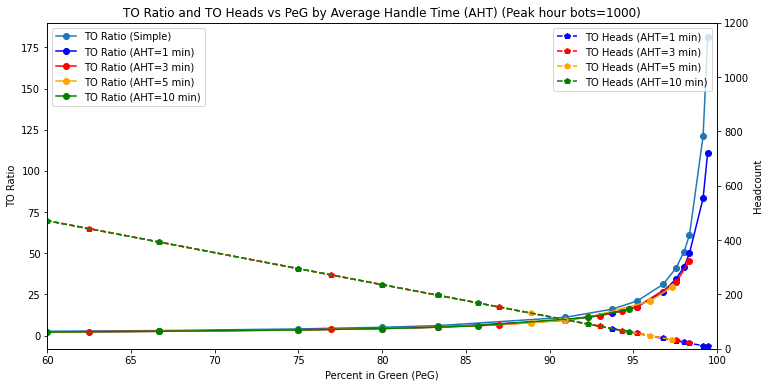

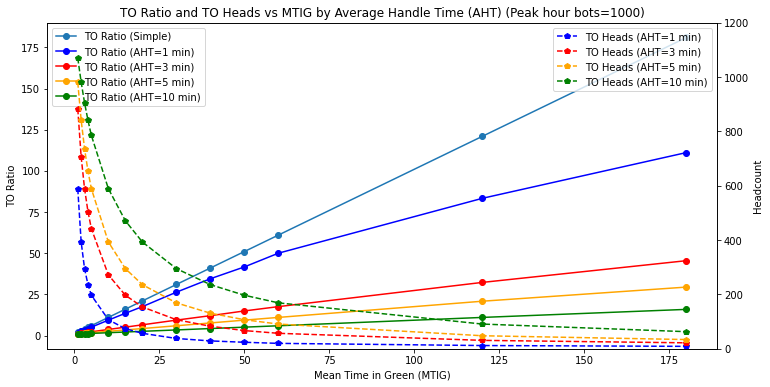

,MTIG,AHT,Peak_bots,Time_interval,Tgt_ASA,Pct_TO_unavailable,Tgt_service_level,Max_occupancy,Assist_reqs_per_hr,Traffic_intensity,Raw_positions,Positions,Service_level,Achieved_occupancy,Wait_probability,chk_ASA,chk_service_level,chk_achieved_occupancy,chk_positions,Pct_in_green,TO_ratio,TO_ratio_simple
0,1.0,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,10000.000000,833.333333,981.0,981.0,1.000000,0.849473,3.582161e-07,1.212921e-08,1.000000,0.849473,981.0,0.166667,1.019368,1.2
1,2.0,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,8571.428571,714.285714,841.0,841.0,1.000000,0.849329,2.211281e-06,8.725462e-08,1.000000,0.849329,841.0,0.285714,1.189061,1.4
2,3.0,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,7500.000000,625.000000,736.0,736.0,1.000000,0.849185,8.735456e-06,3.934890e-07,1.000000,0.849185,736.0,0.375000,1.358696,1.6
3,4.0,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,6666.666667,555.555556,654.0,654.0,1.000000,0.849473,2.711846e-05,1.377349e-06,1.000000,0.849473,654.0,0.444444,1.529052,1.8
4,5.0,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,6000.000000,500.000000,589.0,589.0,1.000000,0.848896,6.083418e-05,3.417651e-06,1.000000,0.848896,589.0,0.500000,1.697793,2.0
5,10.0,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,4000.000000,333.333333,393.0,393.0,0.999984,0.848176,8.515962e-04,7.136281e-05,0.999984,0.848176,393.0,0.666667,2.544529,3.0
6,15.0,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,3000.000000,250.000000,295.0,295.0,0.999835,0.847458,3.314456e-03,3.682728e-04,0.999835,0.847458,295.0,0.750000,3.389831,4.0
7,20.0,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,2400.000000,200.000000,236.0,236.0,0.999278,0.847458,7.961201e-03,1.105722e-03,0.999278,0.847458,236.0,0.800000,4.237288,5.0
8,30.0,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,1714.285714,142.857143,169.0,169.0,0.996382,0.845309,2.066981e-02,3.953242e-03,0.996382,0.845309,169.0,0.857143,5.917160,7.0
9,40.0,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,1333.333333,111.111111,131.0,131.0,0.988752,0.848176,4.235547e-02,1.064802e-02,0.988752,0.848176,131.0,0.888889,7.633588,9.0


In [12]:
mtig_values = [1,2,3,4,5,10,15,20,30,40,50,60,120,180] # minutes
df1=erlang_df(mtig_values, aht = 1)
df3=erlang_df(mtig_values, aht = 3)
df5=erlang_df(mtig_values, aht = 5)
df10=erlang_df(mtig_values, aht = 10)
plt.rcParams["figure.figsize"] = (12,6)
fig, ax1 = plt.subplots()
ax1.plot(df1['Pct_in_green']*100, df1['TO_ratio_simple'], marker="o", label="TO Ratio (Simple)")
ax1.plot(df1['Pct_in_green']*100, df1['TO_ratio'], color = "blue", marker="o", label="TO Ratio (AHT=1 min)")
ax1.plot(df3['Pct_in_green']*100, df3['TO_ratio'], color = "red", marker="o", label="TO Ratio (AHT=3 min)")
ax1.plot(df5['Pct_in_green']*100, df5['TO_ratio'], color = "orange", marker="o", label="TO Ratio (AHT=5 min)")
ax1.plot(df10['Pct_in_green']*100, df10['TO_ratio'], color = "green", marker="o", label="TO Ratio (AHT=10 min)")
ax1.set_ylabel('TO Ratio')
ax1.set_xlabel('Percent in Green (PeG)')
ax1.set_xlim(60,100)
plt.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('Headcount')
ax2.set_ylim(0, 1200)
ax2.plot(df1['Pct_in_green']*100, df1['Positions'], "p--", color = "blue", label="TO Heads (AHT=1 min)")
ax2.plot(df3['Pct_in_green']*100, df3['Positions'], "p--", color = "red", label="TO Heads (AHT=3 min)")
ax2.plot(df5['Pct_in_green']*100, df5['Positions'], "p--", color = "orange", label="TO Heads (AHT=5 min)")
ax2.plot(df10['Pct_in_green']*100, df10['Positions'], "p--", color = "green", label="TO Heads (AHT=10 min)")
plt.legend()
plt.title('TO Ratio and TO Heads vs PeG by Average Handle Time (AHT) (Peak hour bots=1000)')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(df1['MTIG'], df1['TO_ratio_simple'], marker="o", label="TO Ratio (Simple)")
ax1.plot(df1['MTIG'], df1['TO_ratio'], color = "blue", marker="o", label="TO Ratio (AHT=1 min)")
ax1.plot(df3['MTIG'], df3['TO_ratio'], color = "red", marker="o", label="TO Ratio (AHT=3 min)")
ax1.plot(df5['MTIG'], df5['TO_ratio'], color = "orange", marker="o", label="TO Ratio (AHT=5 min)")
ax1.plot(df10['MTIG'], df10['TO_ratio'], color = "green", marker="o", label="TO Ratio (AHT=10 min)")
ax1.set_ylabel('TO Ratio')
ax1.set_xlabel('Mean Time in Green (MTIG)')
#ax1.set_xlim(0,120)
plt.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('Headcount')
ax2.set_ylim(0, 1200)
ax2.plot(df1['MTIG'], df1['Positions'], "p--", color = "blue", label="TO Heads (AHT=1 min)")
ax2.plot(df3['MTIG'], df3['Positions'], "p--", color = "red", label="TO Heads (AHT=3 min)")
ax2.plot(df5['MTIG'], df5['Positions'], "p--", color = "orange", label="TO Heads (AHT=5 min)")
ax2.plot(df10['MTIG'], df10['Positions'], "p--", color = "green", label="TO Heads (AHT=10 min)")
plt.legend()
plt.title('TO Ratio and TO Heads vs MTIG by Average Handle Time (AHT) (Peak hour bots=1000)')
plt.show()

df5

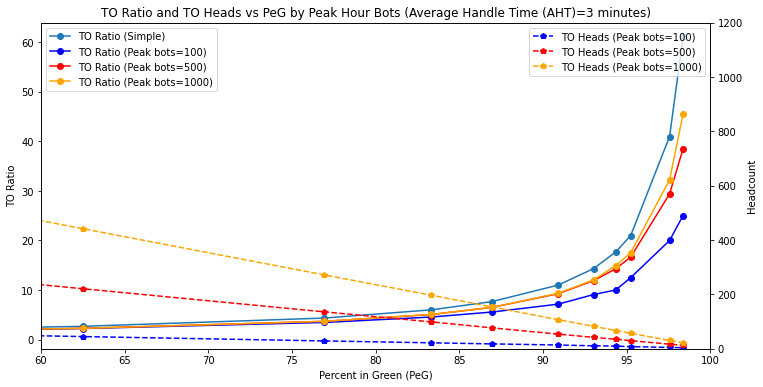

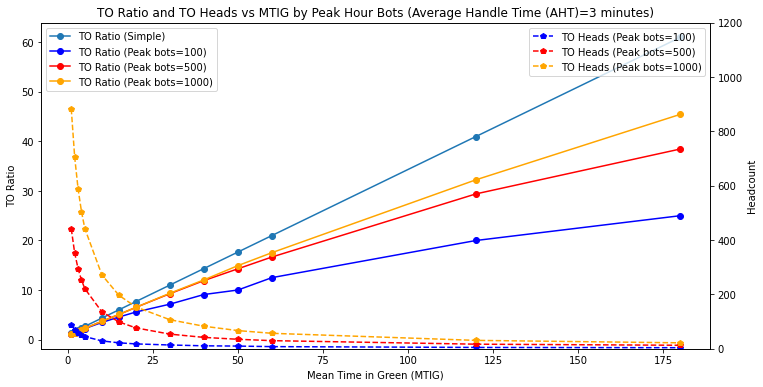

,MTIG,AHT,Peak_bots,Time_interval,Tgt_ASA,Pct_TO_unavailable,Tgt_service_level,Max_occupancy,Assist_reqs_per_hr,Traffic_intensity,Raw_positions,Positions,Service_level,Achieved_occupancy,Wait_probability,chk_ASA,chk_service_level,chk_achieved_occupancy,chk_positions,Pct_in_green,TO_ratio,TO_ratio_simple
0,1.0,3.0,100.0,60.0,0.333333,0.0,0.9,0.85,1500.000000,75.000000,89.0,89.0,0.983724,0.842697,0.077112,0.016524,0.983724,0.842697,89.0,0.250000,1.123596,1.333333
1,2.0,3.0,100.0,60.0,0.333333,0.0,0.9,0.85,1200.000000,60.000000,71.0,71.0,0.966223,0.845070,0.114664,0.031272,0.966223,0.845070,71.0,0.400000,1.408451,1.666667
2,3.0,3.0,100.0,60.0,0.333333,0.0,0.9,0.85,1000.000000,50.000000,59.0,59.0,0.944150,0.847458,0.151817,0.050606,0.944150,0.847458,59.0,0.500000,1.694915,2.000000
3,4.0,3.0,100.0,60.0,0.333333,0.0,0.9,0.85,857.142857,42.857143,51.0,51.0,0.934769,0.840336,0.161208,0.059392,0.934769,0.840336,51.0,0.571429,1.960784,2.333333
4,5.0,3.0,100.0,60.0,0.333333,0.0,0.9,0.85,750.000000,37.500000,45.0,45.0,0.926997,0.833333,0.167979,0.067191,0.926997,0.833333,45.0,0.625000,2.222222,2.666667
5,10.0,3.0,100.0,60.0,0.333333,0.0,0.9,0.85,461.538462,23.076923,29.0,29.0,0.911489,0.795756,0.170929,0.086574,0.911489,0.795756,29.0,0.769231,3.448276,4.333333
6,15.0,3.0,100.0,60.0,0.333333,0.0,0.9,0.85,333.333333,16.666667,22.0,22.0,0.914397,0.757576,0.154829,0.087091,0.914397,0.757576,22.0,0.833333,4.545455,6.000000
7,20.0,3.0,100.0,60.0,0.333333,0.0,0.9,0.85,260.869565,13.043478,18.0,18.0,0.918313,0.724638,0.141687,0.085758,0.918313,0.724638,18.0,0.869565,5.555556,7.666667
8,30.0,3.0,100.0,60.0,0.333333,0.0,0.9,0.85,181.818182,9.090909,14.0,14.0,0.944764,0.649351,0.095303,0.058241,0.944764,0.649351,14.0,0.909091,7.142857,11.000000
9,40.0,3.0,100.0,60.0,0.333333,0.0,0.9,0.85,139.534884,6.976744,11.0,11.0,0.923964,0.634249,0.118894,0.088655,0.923964,0.634249,11.0,0.930233,9.090909,14.333333


In [6]:
mtig_values = [1,2,3,4,5,10,15,20,30,40,50,60,120,180] # minutes
df1=erlang_df(mtig_values, peak_bots = 100)
df3=erlang_df(mtig_values, peak_bots = 500)
df5=erlang_df(mtig_values, peak_bots = 1000)
plt.rcParams["figure.figsize"] = (12,6)
fig, ax1 = plt.subplots()
ax1.plot(df1['Pct_in_green']*100, df1['TO_ratio_simple'], marker="o", label="TO Ratio (Simple)")
ax1.plot(df1['Pct_in_green']*100, df1['TO_ratio'], color = "blue", marker="o", label="TO Ratio (Peak bots=100)")
ax1.plot(df3['Pct_in_green']*100, df3['TO_ratio'], color = "red", marker="o", label="TO Ratio (Peak bots=500)")
ax1.plot(df5['Pct_in_green']*100, df5['TO_ratio'], color = "orange", marker="o", label="TO Ratio (Peak bots=1000)")
ax1.set_ylabel('TO Ratio')
ax1.set_xlabel('Percent in Green (PeG)')
ax1.set_xlim(60,100)
plt.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('Headcount')
ax2.set_ylim(0, 1200)
ax2.plot(df1['Pct_in_green']*100, df1['Positions'], "p--", color = "blue", label="TO Heads (Peak bots=100)")
ax2.plot(df3['Pct_in_green']*100, df3['Positions'], "p--", color = "red", label="TO Heads (Peak bots=500)")
ax2.plot(df5['Pct_in_green']*100, df5['Positions'], "p--", color = "orange", label="TO Heads (Peak bots=1000)")
plt.legend()
plt.title('TO Ratio and TO Heads vs PeG by Peak Hour Bots (Average Handle Time (AHT)=3 minutes)')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(df1['MTIG'], df1['TO_ratio_simple'], marker="o", label="TO Ratio (Simple)")
ax1.plot(df1['MTIG'], df1['TO_ratio'], color = "blue", marker="o", label="TO Ratio (Peak bots=100)")
ax1.plot(df3['MTIG'], df3['TO_ratio'], color = "red", marker="o", label="TO Ratio (Peak bots=500)")
ax1.plot(df5['MTIG'], df5['TO_ratio'], color = "orange", marker="o", label="TO Ratio (Peak bots=1000)")
ax1.set_ylabel('TO Ratio')
ax1.set_xlabel('Mean Time in Green (MTIG)')
#ax1.set_xlim(0,120)
plt.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('Headcount')
ax2.set_ylim(0, 1200)
ax2.plot(df1['MTIG'], df1['Positions'], "p--", color = "blue", label="TO Heads (Peak bots=100)")
ax2.plot(df3['MTIG'], df3['Positions'], "p--", color = "red", label="TO Heads (Peak bots=500)")
ax2.plot(df5['MTIG'], df5['Positions'], "p--", color = "orange", label="TO Heads (Peak bots=1000)")
plt.legend()
plt.title('TO Ratio and TO Heads vs MTIG by Peak Hour Bots (Average Handle Time (AHT)=3 minutes)')
plt.show()

df1

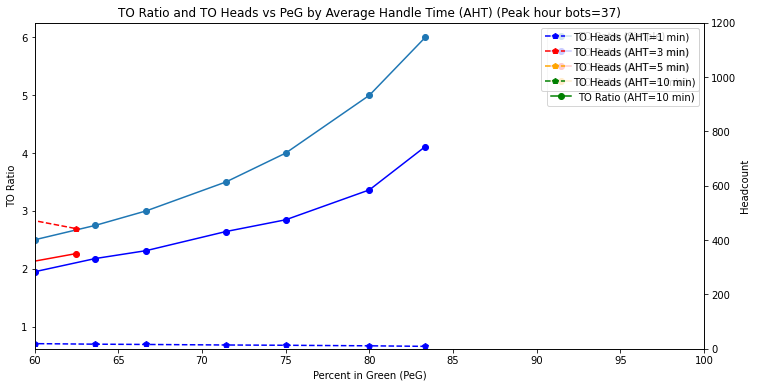

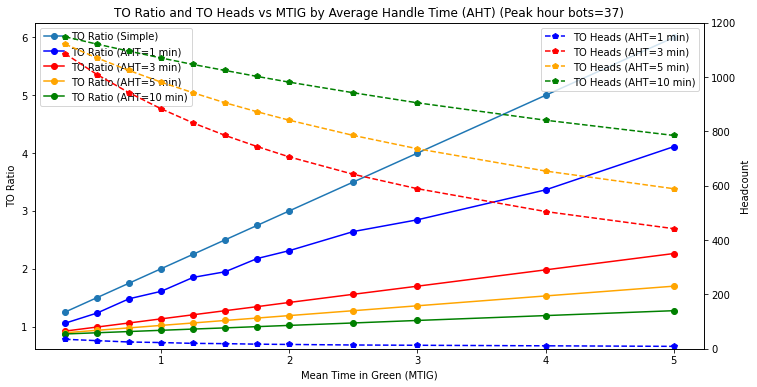

,MTIG,AHT,Peak_bots,Time_interval,Tgt_ASA,Pct_TO_unavailable,Tgt_service_level,Max_occupancy,Assist_reqs_per_hr,Traffic_intensity,Raw_positions,Positions,Service_level,Achieved_occupancy,Wait_probability,chk_ASA,chk_service_level,chk_achieved_occupancy,chk_positions,Pct_in_green,TO_ratio,TO_ratio_simple
0,0.25,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,11428.571429,952.380952,1121.0,1121.0,1.0,0.849582,5.861380e-08,1.738054e-09,1.0,0.849582,1121.0,0.047619,0.892061,1.05
1,0.50,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,10909.090909,909.090909,1070.0,1070.0,1.0,0.849618,1.148425e-07,3.568552e-09,1.0,0.849618,1070.0,0.090909,0.934579,1.10
2,0.75,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,10434.782609,869.565217,1024.0,1024.0,1.0,0.849185,1.930676e-07,6.250780e-09,1.0,0.849185,1024.0,0.130435,0.976562,1.15
3,1.00,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,10000.000000,833.333333,981.0,981.0,1.0,0.849473,3.582161e-07,1.212921e-08,1.0,0.849473,981.0,0.166667,1.019368,1.20
4,1.25,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,9600.000000,800.000000,942.0,942.0,1.0,0.849257,5.757613e-07,2.027329e-08,1.0,0.849257,942.0,0.200000,1.061571,1.25
5,1.50,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,9230.769231,769.230769,905.0,905.0,1.0,0.849979,1.058090e-06,3.896650e-08,1.0,0.849979,905.0,0.230769,1.104972,1.30
6,1.75,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,8888.888889,740.740741,872.0,872.0,1.0,0.849473,1.502269e-06,5.722528e-08,1.0,0.849473,872.0,0.259259,1.146789,1.35
7,2.00,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,8571.428571,714.285714,841.0,841.0,1.0,0.849329,2.211281e-06,8.725462e-08,1.0,0.849329,841.0,0.285714,1.189061,1.40
8,2.50,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,8000.000000,666.666667,785.0,785.0,1.0,0.849257,4.596067e-06,1.942000e-07,1.0,0.849257,785.0,0.333333,1.273885,1.50
9,3.00,5.0,1000.0,60.0,0.333333,0.0,0.9,0.85,7500.000000,625.000000,736.0,736.0,1.0,0.849185,8.735456e-06,3.934890e-07,1.0,0.849185,736.0,0.375000,1.358696,1.60


In [16]:
mtig_values = [0.25,0.5,0.75,1,1.25, 1.5,1.75,2,2.5,3,4,5] # minutes
df1=erlang_df(mtig_values, aht = 1, peak_bots=37)
df3=erlang_df(mtig_values, aht = 3)
df5=erlang_df(mtig_values, aht = 5)
df10=erlang_df(mtig_values, aht = 10)
plt.rcParams["figure.figsize"] = (12,6)
fig, ax1 = plt.subplots()
ax1.plot(df1['Pct_in_green']*100, df1['TO_ratio_simple'], marker="o", label="TO Ratio (Simple)")
ax1.plot(df1['Pct_in_green']*100, df1['TO_ratio'], color = "blue", marker="o", label="TO Ratio (AHT=1 min)")
ax1.plot(df3['Pct_in_green']*100, df3['TO_ratio'], color = "red", marker="o", label="TO Ratio (AHT=3 min)")
ax1.plot(df5['Pct_in_green']*100, df5['TO_ratio'], color = "orange", marker="o", label="TO Ratio (AHT=5 min)")
ax1.plot(df10['Pct_in_green']*100, df10['TO_ratio'], color = "green", marker="o", label="TO Ratio (AHT=10 min)")
ax1.set_ylabel('TO Ratio')
ax1.set_xlabel('Percent in Green (PeG)')
ax1.set_xlim(60,100)
plt.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('Headcount')
ax2.set_ylim(0, 1200)
ax2.plot(df1['Pct_in_green']*100, df1['Positions'], "p--", color = "blue", label="TO Heads (AHT=1 min)")
ax2.plot(df3['Pct_in_green']*100, df3['Positions'], "p--", color = "red", label="TO Heads (AHT=3 min)")
ax2.plot(df5['Pct_in_green']*100, df5['Positions'], "p--", color = "orange", label="TO Heads (AHT=5 min)")
ax2.plot(df10['Pct_in_green']*100, df10['Positions'], "p--", color = "green", label="TO Heads (AHT=10 min)")
plt.legend()
plt.title('TO Ratio and TO Heads vs PeG by Average Handle Time (AHT) (Peak hour bots=37)')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(df1['MTIG'], df1['TO_ratio_simple'], marker="o", label="TO Ratio (Simple)")
ax1.plot(df1['MTIG'], df1['TO_ratio'], color = "blue", marker="o", label="TO Ratio (AHT=1 min)")
ax1.plot(df3['MTIG'], df3['TO_ratio'], color = "red", marker="o", label="TO Ratio (AHT=3 min)")
ax1.plot(df5['MTIG'], df5['TO_ratio'], color = "orange", marker="o", label="TO Ratio (AHT=5 min)")
ax1.plot(df10['MTIG'], df10['TO_ratio'], color = "green", marker="o", label="TO Ratio (AHT=10 min)")
ax1.set_ylabel('TO Ratio')
ax1.set_xlabel('Mean Time in Green (MTIG)')
#ax1.set_xlim(0,120)
plt.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('Headcount')
ax2.set_ylim(0, 1200)
ax2.plot(df1['MTIG'], df1['Positions'], "p--", color = "blue", label="TO Heads (AHT=1 min)")
ax2.plot(df3['MTIG'], df3['Positions'], "p--", color = "red", label="TO Heads (AHT=3 min)")
ax2.plot(df5['MTIG'], df5['Positions'], "p--", color = "orange", label="TO Heads (AHT=5 min)")
ax2.plot(df10['MTIG'], df10['Positions'], "p--", color = "green", label="TO Heads (AHT=10 min)")
plt.legend()
plt.title('TO Ratio and TO Heads vs MTIG by Average Handle Time (AHT) (Peak hour bots=37)')
plt.show()

df5

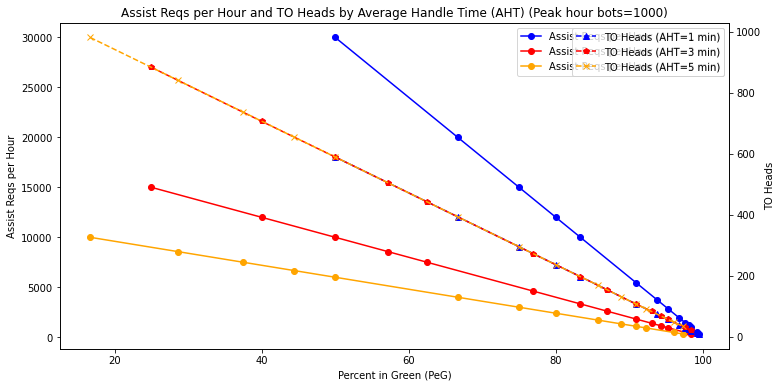

In [14]:
fig, ax1 = plt.subplots()
ax1.plot(df1['Pct_in_green']*100, df1['Assist_reqs_per_hr'], color = "blue", marker="o", label="Assist Reqs per Hour (AHT=1 min)")
ax1.plot(df3['Pct_in_green']*100, df3['Assist_reqs_per_hr'], color = "red", marker="o", label="Assist Reqs per Hour (AHT=3 min)")
ax1.plot(df5['Pct_in_green']*100, df5['Assist_reqs_per_hr'], color = "orange", marker="o", label="Assist Reqs per Hour (AHT=5 min)")
ax1.set_ylabel('Assist Reqs per Hour')
ax1.set_xlabel('Percent in Green (PeG)')
plt.legend(loc=0)
ax2 = ax1.twinx()
ax2.set_ylabel('TO Heads')
ax2.plot(df1['Pct_in_green']*100, df1['Positions'], "^--", color = "blue", label="TO Heads (AHT=1 min)")
ax2.plot(df3['Pct_in_green']*100, df3['Positions'], "p--", color = "red", label="TO Heads (AHT=3 min)")
ax2.plot(df5['Pct_in_green']*100, df5['Positions'], "x--", color = "orange", label="TO Heads (AHT=5 min)")
plt.legend(loc=1)
plt.title('Assist Reqs per Hour and TO Heads by Average Handle Time (AHT) (Peak hour bots=1000)')
plt.show()

# Intuition is that TO Heads and Assist Reqs per Hour both have a linear rel'n with PeG, but that the
# Assist Reqs per Hour-PeG slope is different foir different AHTs, and TO Heads=PeG slope is same for
# different AHTs, but different slope 

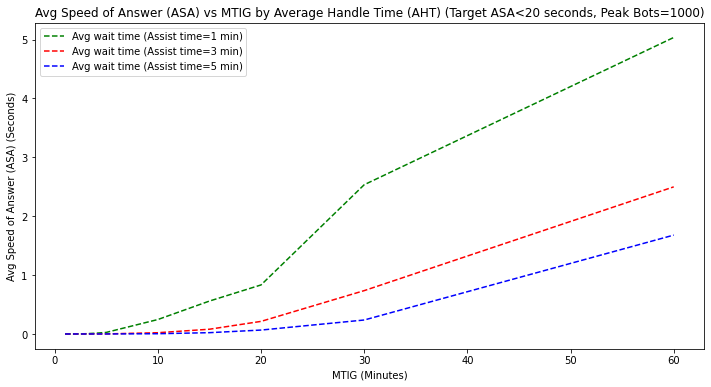

In [472]:
mtig_values = [1,2,3,4,5,10,15,20,30,60] # minutes
df1=erlang_df(mtig_values, aht = 1)
df3=erlang_df(mtig_values, aht = 3)
df5=erlang_df(mtig_values, aht = 5)
plt.plot(df1['MTIG'],df1['chk_ASA']*60,'g--', label="ASA (Assist time=1 min)")
plt.plot(df3['MTIG'],df3['chk_ASA']*60,'r--', label="ASA (Assist time=3 min)")
plt.plot(df5['MTIG'],df5['chk_ASA']*60,'b--', label="ASA (Assist time=5 min)")
plt.xlabel('MTIG (Minutes)')
plt.ylabel('Avg Speed of Answer (ASA) (Seconds)')
plt.title('Avg Speed of Answer (ASA) vs MTIG by Average Handle Time (AHT) (Target ASA<20 seconds, Peak Bots=1000)')
plt.legend()

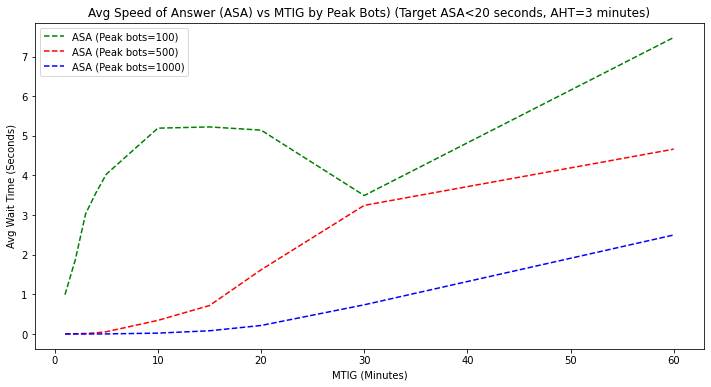

In [7]:
mtig_values = [1,2,3,4,5,10,15,20,30,60] # minutes
df1=erlang_df(mtig_values, peak_bots = 100)
df3=erlang_df(mtig_values, peak_bots = 500)
df5=erlang_df(mtig_values, peak_bots = 1000)
plt.plot(df1['MTIG'],df1['chk_ASA']*60,'g--', label="ASA (Peak bots=100)")
plt.plot(df3['MTIG'],df3['chk_ASA']*60,'r--', label="ASA (Peak bots=500)")
plt.plot(df5['MTIG'],df5['chk_ASA']*60,'b--', label="ASA (Peak bots=1000)")
plt.xlabel('MTIG (Minutes)')
plt.ylabel('Avg Wait Time (Seconds)')
plt.title('Avg Speed of Answer (ASA) vs MTIG by Peak Bots) (Target ASA<20 seconds, AHT=3 minutes)')
plt.legend()